In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Web Scraping Libraries
import urllib
import requests
from bs4 import BeautifulSoup

# Regex Library
import re

# Time-related Libraries
import time
import datetime

# NLP Libraries
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Helper functions
import MVP_Bojado, MVP_Shi

# Environment file
import env, env_Shi

# AWS
import logging
import boto3
from botocore.exceptions import ClientError

# Geospatial Libraries
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium


import json
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings("ignore")

## Data Acquisition

<div class="alert alert-block alert-success"><b>All the functions in the Data Acquisitioin section have been tested out and inorporated into the MVP_acquire_ds.py and MVP_acquire_wd.py files. To save space, no extra test is carried out in this notebook.</b></div>

### URL Format of Indeed.com
1. Search chemist in TX<br>
https://www.indeed.com/jobs?q=chemist&l=TX
2. Search chemist in San Antonio, TX<br>
https://www.indeed.com/jobs?q=chemist&l=San+Antonio%2C+TX
3. Search data scientist in San Antonio, TX<br>
https://www.indeed.com/jobs?q=data+scientist&l=San+Antonio%2C+TX
4. Search data scientist intern in San Anotnio, TX<br>
https://www.indeed.com/jobs?q=data+scientist+intern&l=San+Antonio%2C+TX
5. Sort the data scientist jobs posting by date<br>
https://www.indeed.com/jobs?q=data+scientist&l=San+Antonio%2C+TX&sort=date

**Takeaways**
1. q = job title
2. l = location

### URL Format of Monster.com
https://www.monster.com/jobs/search/?q=data-scientist&where=San-Antonio__2C-TX

### Generate the URL of a Job Search at Indeed.com

In [ ]:
def first_page_url_indeed(job_title, location):
    '''
    This function returns a URL of the 1st page of a job search at Indeed.com 
    based on the job title and the location.
    '''
    # Create the base URL for a job serch at Indeed.com
    base_url = 'https://www.indeed.com/jobs?'
    # Create a dictionary to map the keys to the input parameters
    dic = {'q': job_title, 'l': location, 'sort': 'date'}
    # Convert the dictionary to a query string
    relative_url = urllib.parse.urlencode(dic)
    # Generate the full URL of the first page
    url = base_url + relative_url
    return url

### Make the HTTP Request

In [ ]:
def first_page_soup_indeed(job_title, location):
    '''
    This function returns a BeautifulSoup object to hold the content 
    of the first page of a request for job searching at Indeed.com
    '''
    # Generate the URL of the job search based on title and location
    url = first_page_url_indeed(job_title, location)
    # Make the HTTP request
    response = requests.get(url)
    # Print the status code of the request
    print("Status code of the request: ", response.status_code)
    # Sanity check to make sure the document type is HTML
    print("Document type: ", response.text[:15])
    # Take a break
    time.sleep(5)
    # Make a soup to hold the response content
    soup = BeautifulSoup(response.content, "html.parser")
    # Print out the title of the content
    print("Title of the response: ", soup.title.string)
    return soup

In [ ]:
# first_page_soup = first_page_soup_indeed("data scientist", 'al')
# type(first_page_soup)

# # Find out the tag that contains the number of the jobs by seaching

# num_jobs = first_page_soup.find('div', id='searchCountPages')
# print("Data Type: ", type(num_jobs))
# print("Name of the Tag: ", num_jobs.name)
# print("Attributes of the Tag: ", num_jobs.attrs)
# print("Text within the Tag: ")
# num_jobs.text

# # Find the number of the jobs in the text
# match = re.findall(r'(\d+)', num_jobs.text)
# match[1]

In [ ]:
def num_jobs_indeed(first_page_soup):
    '''
    This function returns the total number of the jobs in the searching result.
    '''
    # Find out the section contains total number of jobs  
    div = first_page_soup.find('div', id='searchCountPages')
    # Extract the number
    num_jobs = re.findall(r'(\d+)', div.text)[1]
    return num_jobs

In [ ]:
def page_num_indeed(url):
    '''
    This function returns the page number of job searching results. 
    '''
    # Create a Soup object based on the url
    soup = page_soup_indeed(url)
    # Find out the section contains total number of jobs  
    div = soup.find('div', id='searchCountPages')
    # Extract the number
    page_num = re.findall(r'(\d+)', div.text)[0]
    return page_num

In [ ]:
# Define a function to extract all job cards in a Indeed page

def job_cards_indeed(soup):
    '''
    This function accepts the Soup object of a Indeed page 
    return an iterator containing the all the job cards in this page.
    '''
    # Find the appropriate tag that contains all of the job listings in this page
    tag = soup.find('td', id="resultsCol")
    # Extract all job cards
    job_cards = tag.find_all('div', class_='jobsearch-SerpJobCard')
    return job_cards

In [ ]:
# # Test the function job_cards_indeed
# job_cards = job_cards_indeed(first_page_soup)

# # Print the data type of job_cards
# type(job_cards)

# # How many jobs listed in the 1st page? 
# len(job_cards)

In [ ]:
def job_titles_indeed(job_cards):
    '''
    This function extract the job titles from a job_cards set. 
    '''
    # Create a list to hold the job titles
    titles = []
    # For Loop throught the job cards to extract the titles
    for job in job_cards:
        title = job.find('h2', class_='title')
        title = title.text.strip()
        titles.append(title)
    return titles

In [ ]:
# Define a function to pull the company names from a set of job cards

def company_names_indeed(job_cards):
    '''
    This function extracts the company names from a set of job cards.
    '''
    # Create a list to hold the company names
    names = []
    # For loop through the job cards to pull the company names
    for job in job_cards:
        name = job.find('span', class_='company')
        name = name.text.strip()
        names.append(name)
    return names

In [ ]:
# Define a function to pull the post ages from a set of job cards

def post_ages_indeed(job_cards):
    '''
    This function pulls the post ages from a set of job cards.
    '''
    # Create a list to hold the post ages
    ages = []
    # For loop through the job cards to pull the post ages
    for job in job_cards:
        age = job.find('span', class_='date')
        age = age.text.strip()
        ages.append(age)
    return ages

In [ ]:
# Define a function to pull the location from a set of job cards

def job_locations_indeed(job_cards):
    '''
    This function pulls the job locations from a set of job cards.
    '''
    # Create a list to hold the locations
    locations = []
    # For loop through the job cards to pull the locations
    for job in job_cards:
        location = job.find('div', class_='location accessible-contrast-color-location')
        if location == None:
            location = job.find('span', class_='location accessible-contrast-color-location')
        location = location.text.strip()
        locations.append(location)
    return locations

In [ ]:
# Define a function to pull the company ratings from a set of job cards

def company_rating_indeed(job_cards):
    '''
    This function pulls the company rating from a set of job cards.
    If the rating is unavailable, it will be marked as 'missing'.
    '''
    # Create a list to hold the locations
    ratings = []
    # For loop through the job cards to pull the locations
    for job in job_cards:
        rating = job.find('span', class_='ratingsContent')
        if rating == None:
            ratings.append('missing')
            continue
        rating = rating.text.strip()
        ratings.append(rating)
    return ratings

In [ ]:
def acuqire_indeed_job_description(url):
    '''
    This function accepts the URL of a job posting and pull its description.
    '''
    # Make the HTTP request
    request = requests.get(url)
    print("Status Code: ", request.status_code)
    # Take a break
    time.sleep(5)
    # Make a soup variable holding the response content
    soup = BeautifulSoup(request.content, "html.parser")
    if soup == None:
        description = 'error'
    else:
        # Print the page's title
        print(soup.title.string)
        # Find the section that contains job description
        description = soup.find('div', id="jobDescriptionText")
        if description == None:
            description = 'error'
        else:
            description = description.text
    return description

def job_links_and_contents_indeed(job_cards):
    '''
    This function pulls the job links and descriptions from a set of job cards.
    '''
    # Create a list to hold the links and descriptions
    links = []
    descriptions = []
    # For loop through the job cards to pull the links and descriptions
    for job in job_cards:
        link = job.find('a')['href']
        link = 'https://www.indeed.com' + link
        link = link.replace(';', '&')
        description = acuqire_indeed_job_description(link)
        links.append(link)
        descriptions.append(description)
    return links, descriptions

In [ ]:
# Define a function to create a Soup object based on a job search url

def page_soup_indeed(url):
    '''
    This function returns a BeautifulSoup object to hold the content 
    of a page for a job searching results at Indeed.com
    '''
    # Make the HTTP request
    response = requests.get(url)
    # Print the status code of the request
    print("Status code of the request: ", response.status_code)
    # Sanity check to make sure the document type is HTML
    print("Document type: ", response.text[:15])
    # Take a break
    time.sleep(5)
    # Make a soup to hold the response content
    soup = BeautifulSoup(response.content, "html.parser")
    # Print out the title of the content
    print("Title of the response: ", soup.title.string)
    return soup

In [ ]:
# # Test the function: page_soup_indeed

# url = 'https://www.indeed.com/jobs?q=data+scientist&l=al&sort=date'
# soup = page_soup_indeed(url)
# type(soup)

# # Find out the page number
# int(page_num_indeed(url))

# # Pull the job cards from the soup
# type(job_cards_indeed(soup))

In [ ]:
# Define a function to pull job information from a job search URL

def acquire_page_indeed(url):
    '''
    This function accepts a job search URL and returns a pandas dataframe 
    containing job title, location, company, company rating, post age and description. 
    '''
    # Create a Soup object based on the url
    soup = page_soup_indeed(url)
    # Pull the job cards
    job_cards = job_cards_indeed(soup)
    # Pull the job titles
    titles = job_titles_indeed(job_cards)   
    # Pull the names of the companies
    companies = company_names_indeed(job_cards)
    # Pull the post ages
    ages = post_ages_indeed(job_cards)
    # Pull the job locations
    locations = job_locations_indeed(job_cards)
    # Pull the company ratings
    ratings = company_rating_indeed(job_cards)
    # Pull the hyperlinks and job description
    links, descriptions = job_links_and_contents_indeed(job_cards)    
    # Create a dataframe
    d = {'title': titles,
         'location': locations,
         'company': companies, 
         'company_rating': ratings,
         'post_age': ages, 
         'job_link': links, 
         'job_description': descriptions}
    df = pd.DataFrame(d)
    return df

In [ ]:
def jobs_indeed(job_title, location, max_page=35):
    '''
    This function accepts the job title and location and return the job information (35 pages by default) 
    pulled from Indeed.com.
    '''
    # Generate the urls based on job title and location (state)
    url = first_page_url = first_page_url_indeed(job_title, location)
    # Set up an counter
    counter = 1
    # Create an empty dataframe to hold the job information
    df_jobs = pd.DataFrame(columns = ['title', 'location', 'company', 'company_rating', 
                                      'post_age','job_link', 'job_description'])
    # Pull the page number
    page_num = int(page_num_indeed(url))
    # Set up an checker
    keep_going = (counter == page_num)   
    # For loop through the urls to pull job information
    while keep_going and page_num <= max_page:
        df = acquire_page_indeed(url)
        print("--------------------------------")
        print("Page: ", page_num)
        print("--------------------------------")
        df_jobs = df_jobs.append(df, ignore_index=True)
        df_jobs.to_csv("df_jobs_backup.csv")
        time.sleep(180)
        dic = {'start': page_num*10}
        relative_url = urllib.parse.urlencode(dic)
        url = first_page_url + '&' + relative_url
        counter = counter + 1
        page_num = int(page_num_indeed(url))
        keep_going = (counter == page_num)
    # Print the total number of jobs
    print(f"Total number of {job_title} positions in {location}: ", df_jobs.shape[0])
    return df_jobs

## Data Preparation

In [2]:
# Define a function to remove the duplicated job postings

def remove_duplicates(df):
    '''
    This function removes the duplicates in the dataframe based on title, location, 
    company, job_link, and job_description
    '''
    # Define the columns for identifying duplicates
    columns = ['title', 'location', 'company', 'job_link', 'job_description']
    # Drop the duplicates except for the last occurrence
    df.drop_duplicates(subset=columns, inplace=True, keep='last')
    return df

In [3]:
# Define a function to compute the date when the jobs are posted

def compute_post_date(df):
    '''
    This function computes the date of a job posting based on its post age
    and set the date as the index of the dataframe.
    '''
    # Create an empty list to hold the post date
    post_date = []
    # For loop the column post_age and convert the values to date
    for age in df.post_age:
        if age == 'Just posted' or == 'Today':
            date = datetime.date.today()
            post_date.append(date)
        else:
            # Extract the number
            num = re.findall(r'(\d+)', age)[0]
            # Cast the string number to integer
            num = int(num)
            # Convert the integer to timedelta object
            num = datetime.timedelta(days=num)
            # Compute post date        
            date = datetime.date.today()
            date = date - num
            post_date.append(date)
    # Add post date as new column
    df['date'] = post_date
    # Set the column post_date as the index and sort the values
    df = df.set_index('date').sort_index(ascending=False)
    return df

In [4]:
# Define a function to clean the job titles for analysis

def clean_job_title(title):
    '''
    This function removes the "\nnew" and "..." in the job title.
    '''
    title = title.split(sep="\nnew")[0]
#     title = title.split(sep=' -')[0]
#     title = title.split(sep=' (')[0]
#     title = title.split(sep=',')[0]
    title = title.split(sep='...')[0]
    return title

In [ ]:
# Define a function to transform old job posts files

def transform_old_file(df, date_string):
    '''
    This function accepts old daily job posts and convert the post age to post date. 
    '''
    # Create an empty list to hold the post date
    post_date = []
    # For loop the column post_age and convert the values to date
    for age in df.post_age:
        if age == 'Just posted':
            date = datetime.date.fromisoformat(date_string)
            post_date.append(date)
        elif age == 'Today':
            date = datetime.date.fromisoformat(date_string)
            post_date.append(date)
        else:
            # Extract the number
            num = re.findall(r'(\d+)', age)[0]
            # Cast the string number to integer
            num = int(num)
            # Convert the integer to timedelta object
            num = datetime.timedelta(days=num)
            # Compute post date        
            date = datetime.date.fromisoformat(date_string)
            date = date - num
            post_date.append(date)
    # Add post date as new column
    df['date'] = post_date
    # Set the column post_date as the index and sort the values
    df = df.set_index('date').sort_index(ascending=False)
    return df

In [5]:
def daily_update(df_new):
    '''
    This function updates and prepares the job posts by adding daily new job postings 
    and save as JSON file. 
    '''
    # Load the job posts based on the inputted job title
    database = env_Shi.database
    print("Enter the INITIALS of the job title:")
    initials = input()
    df = pd.read_csv(f"{database}df_{initials}_tx_backup.csv")
    num_jobs = df.shape[0]
    # Convert the date column to datetime type
    df.date = pd.to_datetime(df.date)
    # Set the date column as the index and sort the index
    df = df.set_index('date').sort_index(ascending=False)
    # Add the daily update
    df_new = compute_post_date(df_new)
    df = pd.concat([df, df_new]).sort_index(ascending=False)
    # Remove the duplicates
    df = remove_duplicates(df)
    # Save as csv file
    df.to_csv(f"{database}df_{initials}_tx_backup.csv")
    num_new_jobs = df.shape[0] - num_jobs
    print("New Jobs of Posted Today: ", num_new_jobs)
    
    # Re-Load the dataset
    df = pd.read_csv(f"{database}df_{initials}_tx_backup.csv")
    # Create columns of city, state, and zipcode
    location = df.location.str.split(', ', expand=True)
    location.columns = ['city', 'zipcode']
    location.city = location.city.apply(lambda i: 0 if i == 'United States' else i)
    location.city = location.city.apply(lambda i: 0 if i == 'Texas' else i)
    location.zipcode = location.zipcode.apply(lambda i: 0 if re.findall(r"(\d+)", str(i)) == [] 
                                              else re.findall(r"(\d+)", str(i))[0])
    df['city'] = location.city
    df['state'] = 'TX'
    df['zipcode'] = location.zipcode
    # Replace the missing values in the company rating with 0
    df.company_rating = df.company_rating.apply(lambda i: 0 if i == 'missing' else i)
    # Clean the text in the job description
    df = MVP_Bojado.prep_job_description_data(df, 'job_description')
    # Clean the job title
    df.title = df.title.apply(clean_job_title)
    # Drop the redundant columns post_age and location
    redundant_cols = ['post_age', 'location', 'tokenized', 'stemmed', 'lemmatized']
    df = df.drop(columns=redundant_cols)
    # Alther the data type of company_rating and zipcode
    df.company_rating = df.company_rating.apply(lambda i: float(i))
    df.zipcode = df.zipcode.apply(lambda i: int(i))
    # Save a JSON version of the prepared data
    df.to_json(f"{database}df_{initials}_tx_prepared_backup.json", orient='records')
    return df

In [38]:
# # Load job posts of web developer in TX on Feb.12 2021

# # Import the file path
# database = env_Shi.database

# # Read the daily data scientist jobs in TX
# df_wd_old = pd.read_csv(f"{database}web_developer_tx_indeed_021221.csv", index_col=0)

# # Print the first 2 rows
# df_wd_old.head(2)

# # Transform old file
# df_wd_old = transform_old_file(df_wd_old, '2021-02-12')
# df_wd_old.head(2)

### Find the Company Address

In [105]:
# Print a link of a job post

sample = df_ds_tx.job_link[1]
sample

'https://www.indeed.com/rc/clk?jk=3ec2fc58833a3965&fccid=1639254ea84748b5&vjs=3'

<div class="alert alert-block alert-info"><b>Takeaways</b>: Detailed physical address can't be found on the Indeed website. It has to be obtained through other approaches. 
</div>

### Daily Update of Job Postings of Data Scientist and Web Developer Positions in TX

In [12]:
# Load the job postings in TX on Feb 25 2021

# Import the file path
database = env_Shi.database

# Read the daily job postings
print("Enter the job title: ")
job_title = input()
job_title = job_title.split()
df_new = pd.read_csv(f"{database}{job_title[0]}_{job_title[1]}_tx_indeed_022521.csv", index_col=0)

# Print the dimentionality
print(df_new.shape)

# Print the first two rows
df_new.head(2)

Enter the job title: 
web developer
(300, 7)


,title,location,company,company_rating,post_age,job_link,job_description
0,WEB DEVELOPER INTERN\nnew,"Dallas, TX 75238 (Northeast Dallas area)",Blanks Financial Solutions,missing,Just posted,https://www.indeed.com/rc/clk?jk=9a84b22936691...,The position\n\n\nWe are looking for a Full St...
1,SharePoint Developer\nnew,"Fort Sam Houston, TX 78234 (Monte Vista area)",KATMAI,3.4,Just posted,https://www.indeed.com/rc/clk?jk=ee6a398a4c63e...,Job Description:\nSUMMARY:\nProvides the USAIS...


In [13]:
%%time
# Perform the daily updates

df_test = daily_update(df_new)
df_test.head(2)

Enter the INITIALS of the job title:
wd
New Jobs of Posted Today:  85
CPU times: user 53.3 s, sys: 389 ms, total: 53.7 s
Wall time: 1min 2s


,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
0,2021-02-25,WEB DEVELOPER INTERN,Blanks Financial Solutions,0.0,https://www.indeed.com/rc/clk?jk=9a84b22936691...,The position\n\n\nWe are looking for a Full St...,Dallas,TX,75238,position looking full stack developer intern e...
1,2021-02-25,Software Engineer (Full Stack),Lightspeed Systems,3.9,https://www.indeed.com/company/Lightspeed-Syst...,Are you a highly experienced Full-stack JavaSc...,Austin,TX,0,highly experienced fullstack javascript softwa...


In [14]:
# Print the information of the dataframe
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4470 entries, 0 to 4469
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             4470 non-null   object 
 1   title            4470 non-null   object 
 2   company          4470 non-null   object 
 3   company_rating   4470 non-null   float64
 4   job_link         4470 non-null   object 
 5   job_description  4470 non-null   object 
 6   city             4470 non-null   object 
 7   state            4470 non-null   object 
 8   zipcode          4470 non-null   int64  
 9   clean            4470 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 349.3+ KB


In [ ]:
# # Adjust the data types

# dtypes = {'company_rating': 'float16', 
#           'zipcode': 'int16'}
# df_test.astype(dtypes).dtypes

<div class="alert alert-block alert-info"><b>Takeaways:</b>
There are two ways to change the datatype: 
</div>

In [15]:
# Define the columns for identifying duplicates
columns = ['date', 'title', 'company', 'job_link', 'job_description', 'city', 'state', 'zipcode']
   
# Check for duplicates
duplicates = df_test.duplicated(subset=columns,keep='last')
duplicates.sum()

665

<div class="alert alert-block alert-info"><b>Takeaways:</b>
After the job titles are cleaned, the duplicates of job postings starts to appear. It suggests that when the same job is re-posted, the job title changes. 
</div>

In [ ]:
# # Read the json file

# result = open(f"{database}df_wd_tx_prepared_backup.json")
# parsed = json.load(result)
# parsed[1]

### Upload Prepared JSON Files to AWS S3 Bucket

In [16]:
%%time
# Upload the json file to AWS

# Create the s3 resource object
s3 = boto3.resource('s3')

# Read the location of the database
database = env_Shi.database

# Create the job title initials
print("Enter the INITIALS of the job title:")
initials = input()

# Upload df_ds_tx_backup.csv file
s3.Bucket(f'{initials}rawjobpostings').upload_file(f"{database}df_{initials}_tx_backup.csv", 
                                                   f"df_{initials}_tx_backup.csv")

# Upload df_ds_tx_prepared_backup.json file
s3.Bucket(f'{initials}preparedjobpostings').upload_file(f"{database}df_{initials}_tx_prepared_backup.json", 
                                                        f"df_{initials}_tx_prepared_backup.json")

Enter the INITIALS of the job title:
wd
CPU times: user 754 ms, sys: 589 ms, total: 1.34 s
Wall time: 36 s


# Data Exploration

In [18]:
# Set a class named color

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

### Acquire the Prepared Dataset From AWS S3

#### List All Buckets in S3

In [22]:
# Create the s3 resource object
s3 = boto3.resource('s3')   # Notes: the datatype of s3 is s3.ServiceResource

# Print the bucket names
print(color.UNDERLINE + color.BOLD + "List of Buckets in S3:" + color.END)
for bucket in s3.buckets.all():
    print(bucket.name)

List of Buckets in S3:
additionaljobinfo
amplify-jobdashboardfront-dev-180611-deployment
dspreparedjobpostings
dsrawjobpostings
wdpreparedjobpostings
wdrawjobpostings


#### List All the Files in a Bucket

In [26]:
# Input the name of the bucket
bucket_name = input()

# Create the bucket object
bucket = s3.Bucket(bucket_name) # Note: the data type of the bucket is s3.Bucket

# List all the files inside the bucket

print(color.UNDERLINE + color.BOLD + f"List of Files in Bucket {bucket_name}:" + color.END)
for page in bucket.objects.pages():
    for obj in page:
        print(obj.key)

additionaljobinfo
List of Files in Bucket additionaljobinfo:
ds_grams.json
ds_top5_general_skills.json
ds_top5_soft_skills.json
ds_top5_tech_skills.json
geospatial_data.csv
soft_skills_cleaned
wd_top5_general_skills.json
wd_top5_soft_skills.json
wd_top5_tech_skills.json


#### Check the Last Modified Datetime for the Prepared JSON Files

In [27]:
# Print the time when the prepared json file is last modified

s3 = boto3.resource("s3")
prepared_json = s3.Object('dspreparedjobpostings', 'df_ds_tx_prepared_backup.json')
print("Last modified time of JSON for data scientist position: ", prepared_json.last_modified)

Last modified time of JSON of data scientist position 2021-02-25 20:31:40+00:00


In [28]:
# When is the df_wd_tx_prepared.json last modified?

s3 = boto3.resource('s3')
prepared_json = s3.Object('wdpreparedjobpostings', 'df_wd_tx_prepared_backup.json')
print("Last modified time of JSON for web developer position: ", prepared_json.last_modified)

Last modified time of JSON for web developer position:  2021-02-25 20:34:53+00:00


#### Down Load JSON Files from AWS

In [5]:
# # Download JSON file from AWS 
# database = env_Shi.database
# s3.Bucket('dsrawjobpostings').download_file('df_ds_tx_backup.csv', 
#                                             f"{database}df_ds_tx_aws.csv")

### Acquire the Prepared Dataset from the Local Database

In [29]:
# Define a function to load JSON file of job postings

def read_job_postings_json():
    '''
    This function reads the JSON file of prepared job postings into a pandas dataframe 
    based on a job title and set the date as the index.
    '''
    # Load the file path of the local database
    database = env_Shi.database
    # Create the file name
    print("Enter the INITIALS of the job title:")
    initials = input()
    file_name = 'df_' + initials + '_tx_prepared_backup.json'
    # Read the JSON file into a pandas dataframe
    df = pd.read_json(f'{database}{file_name}')
    # Print the numbr of job posts
    print("Number of Job Postings: ", df.shape[0])
    # Convert the string date to datetime
    df.date = pd.to_datetime(df.date)
    # Set the date as the index and sort the dataframe
    df = df.set_index('date').sort_index(ascending=False)
    return df

## Exploration of Job Postings for Data Scientist in TX

In [65]:
# Load the dataset
df_ds_tx = read_job_postings_json()

# Print the first 5 rows of the dataframe
df_ds_tx.head()

Enter the INITIALS of the job title:
ds
Number of Job Postings:  2297


,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
date,,,,,,,,,
2021-02-25,Applied Scientist,Amazon.com Services LLC,3.6,https://www.indeed.com/rc/clk?jk=a9dbd4e1ed934...,"\nM.S. in Computer Science, Machine Learning, ...",Austin,TX,0,m computer science machine learning operationa...
2021-02-25,Applied Data Science Manager,dunnhumby,3.8,https://www.indeed.com/rc/clk?jk=2323bfe22c6e5...,Austin\n\nMost companies try to meet expectati...,Austin,TX,0,austin company try meet expectation dunnhumby ...
2021-02-25,Distinguished Data Scientist,Verizon,3.9,https://www.indeed.com/rc/clk?jk=c1a0bcd827fc1...,When you join Verizon\nVerizon is a leading pr...,Irving,TX,75038,join verizon verizon leading provider technolo...
2021-02-25,Data Engineer,Verizon,3.9,https://www.indeed.com/rc/clk?jk=18f2be848788e...,When you join Verizon\nYou’ll have the power t...,Irving,TX,75038,join verizon youll power go beyond work thats ...
2021-02-25,Developer - Mathematical Optimization,Six Flags Entertainment,3.7,https://www.indeed.com/rc/clk?jk=0d70e0a00cd3a...,Job Duties:\nGather business requirements and ...,Arlington,TX,0,job duty gather business requirement translate...


### Breif Summary

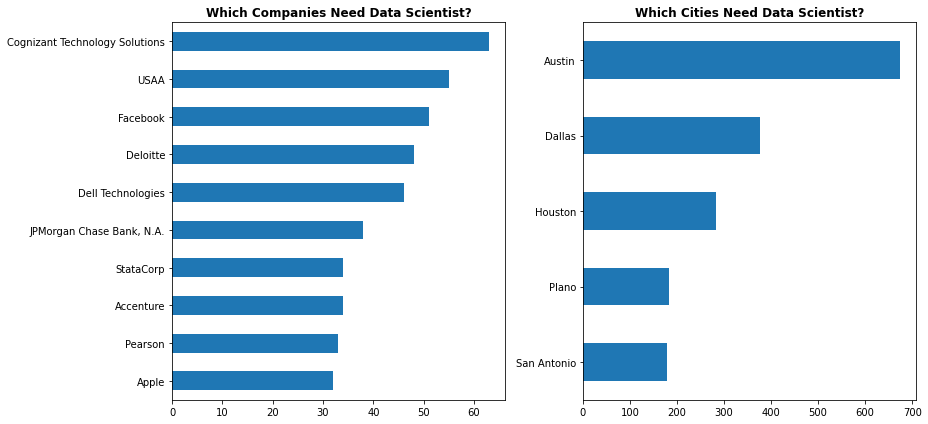

In [113]:
# Barplot the top 10 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_ds_tx.company.value_counts().head(10)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Need Data Scientist?", fontweight='bold')

plt.subplot(122)
top_cities = df_ds_tx.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Need Data Scientist?", fontweight='bold')

plt.tight_layout()
plt.show()

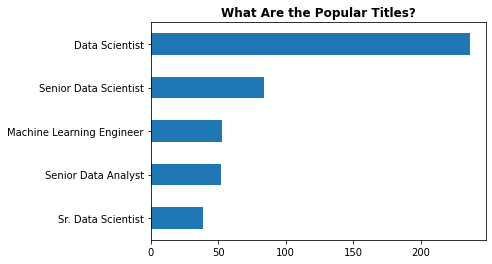

In [116]:
# Barplot the popular titles of the job postings

top_title = df_ds_tx.title.value_counts().head(5)
top_title.sort_values().plot(kind='barh')
plt.title("What Are the Popular Titles?", fontweight='bold')

plt.show()

### Frequency Analysis

In [119]:
# Define the function to create the words that appear in the job descriptions

def words_variables_v1(df):
    '''
    This function accepts the dataframe with cleaned job description 
    and return a dictionary in which the values are the words that 
    appear in the job description. 
    '''
    # Create the words that appear all the job descritipons
    all_words = ' '.join(df.clean)
    # Create a dictionary to hold the variable all_words
    d_words = {'frequency': all_words}
    return d_words

In [ ]:
# Upgrade the function `words_variables_v1`

def words_variables_v2(df, companies):
    '''
    This function accepts the dataframe containing cleaned job description and 
    a list of company names and return a dictionary in which the values are the words 
    that appear in the job description. 
    '''
    # Create the words that appear all the job descritipons
    all_words = ' '.join(df.clean)
    # Create a dictionary to hold the variable all_words
    d_words = {'all': all_words}
    # For loop the companies and create the words that appear in their job descriptions
    for company in companies:
        mask = (df.company == company)
        s_company = df[mask].clean
        words = ' '.join(s_company)
        d_words[company] = words
    return d_words

In [122]:
# Create the words variable
d_words = words_variables_v1(df_ds_tx)

# Print the first characters in the words variable
d_words['frequency'][:100]

'm computer science machine learning operational research statistic related quantitative field 3 year'

In [124]:
# Define a function to compute the frequence of the mono-, bi-, and tri-grams of the job description

def everygram_frequency_v1(d_words, max_len=3):
    '''
    This function accetps the dictionary produced by the function `words_variables_v1` and 
    return mono-, bi-, and tri-grams along with their frequency. 
    '''
    # Generate mono-, bi-, and tri-grams
    grams = nltk.everygrams(d_words['frequency'].split(), max_len=max_len) # dtype of grams: <class 'genertor'>
    # Convert to a list of tuples
    grams = list(grams)
    # Create an empty list to hold mono-, bi-, and tri-grams
    everygram = []
    # For loop the list of tuples and convert the grams to strings
    for gram in grams:
        str_gram = gram[0]
        for i in gram[1:]:
            str_gram = str_gram + ' ' + i
        everygram.append(str_gram)
    # Compute the frequency of the everygrams
    everygram = pd.Series(everygram).value_counts()
    return everygram

In [130]:
# Compute the frequency of mono-, bi-, and tri-grams
gram_frequency = everygram_frequency_v1(d_words)

# Print the top 5 most frequent word(s)
gram_frequency.head()

data          23606
experience    13248
business       8391
team           7480
work           6656
dtype: int64

In [127]:
# # Upload the frequency table to AWS s3 bucket

# # Create the s3 resource object
# s3 = boto3.resource('s3')

# # Read the location of the database
# database = env_Shi.database

# # Upload df_ds_tx_backup.csv file
# s3.Bucket('additionaljobinfo').upload_file(f"{database}ds_grams.json", "ds_grams.json")

### Compute Top 5 Skills in a Predifined Library

In [131]:
# Define a function to pick up the top k skills from a skill library

def top_skills_v1(df, k, library, library_type):
    '''
    This function accepts a positive integer k and a skillset library and 
    returns a dataframe containing the top k skills needed for data scientist positions.
    '''
    # Create a string of all words that appear in the job description
    dic = words_variables_v1(df)
    # Compute the words frequency
    everygram_frequency = everygram_frequency_v1(dic)
    # Create a empty dataframe to hold the rank of the skills
    df_skills = pd.DataFrame()
    # For loop through the library to find out the frequency of the skills mentioned in the job description
    for skill in library:
        mask = (everygram_frequency.index == skill)
        df =  everygram_frequency[mask]
        df_skills = pd.concat([df_skills, df])
    df_skills.columns = dic.keys()
    df_skills.sort_values(by='frequency', ascending=False, inplace=True)
    # Reset the index
    df_skills.reset_index(inplace=True)
    # Rename the column name
    df_skills.rename(columns={'index': f'top{k}_{library_type}_skills'}, inplace=True)
    return df_skills.head(k)

In [140]:
# Create a tech library
ds_tech_library = ['python','sql','pandas','numpy','matplotlib','scikit learn','scikitlearn','spark','hadoop',
                   'aws','amazon web services','azure','microsoft word', 'microsoft excel','excel','tableau',
                   'tensor flow','pytorch','hive','impala','matlab','etl','statistics','exploration',
                   'extraction','data wrangling','math','machine learning','data visualization','java','js',
                   'javascript','scala','r','c','c++','power bi','dashboard','linear algebra','calculus',
                   'neural networks','eda','big data','frameworks','database management','testing hypotheses',
                   'probability','data mining','perl','nosql','saas','git','github',
                   'natural language processing','nlp', 'deep learning','agile','kanban','project management',
                   'julia','devops','google cloud','pytorch','computer vision', 'deep neural networks',
                   'neural networks','amazon web services','natural language processing',
                   'extract,transform,load','mysql','structured query language']
# Print the number of skills in the library
print("Number of skills in tech skill library: ", len(ds_tech_library))

# Compute top 10 technical skills for data scientist position in TX
df_ds_top_tech = top_skills_v1(df_ds_tx, 5, ds_tech_library, 'tech')
df_ds_top_tech

Number of skills in tech skill library:  71


,top5_tech_skills,frequency
0,machine learning,3501.0
1,python,1844.0
2,sql,1412.0
3,aws,1074.0
4,r,1019.0


In [141]:
# Pick up the top 20 soft skills
ds_soft_library = ['critical thinking','communication','problem solving','teamwork','ethics',
                   'business acumen','interpersonal skills','curiosity','storytelling','adaptability',
                   'team player','collaboration','time management','leadership','domain knowledge',
                   'creativity','decision making','verbal communication','written communication','teamwork']
# Print the number of skills in the library
print("Number of skills in soft skill library: ", len(ds_soft_library))

df_ds_top_soft = top_skills_v1(df_ds_tx, 5, ds_soft_library, 'soft')
df_ds_top_soft

Number of skills in soft skill library:  20


,top5_soft_skills,frequency
0,communication,1579.0
1,leadership,975.0
2,collaboration,475.0
3,problem solving,351.0
4,written communication,262.0


### Time Series Analysis
- Centered on Skills

In [161]:
# Define a function to add the frequencies of the skills in each observation

def add_skill_frequency(df, df_top):
    '''
    This function accepts the dataframe of prepared job postings and the dataframe of the top k skills
    and adds the frequencies of the skills in each observation.
    '''
    # Reset the index of the df
    df_copy = df.reset_index()
    # Create a list of the top skills
    skill_list = df_top.iloc[:, 0].to_list()
    # Create an empty dictionary to hold the frequency of the skill in each observation
    dic_frequency = {}
    # Loop through the list of skills to compute its frequency in each observation
    for skill in skill_list:
        list_frequency = []
        for string in df_copy.clean.values:
            matches = re.findall(f" {skill} ", string)
            frequency = len(matches)
            list_frequency.append(frequency)
        dic_frequency[skill]=list_frequency    
    # Convert the dictionary into the dataframe
    df_frequency = pd.DataFrame(dic_frequency)
    # Add the frequencies of the top skills to the original dataframe
    df_copy = pd.concat([df_copy, df_frequency], axis=1)
    # Reset the date as the index
    df_copy = df_copy.set_index('date')
    return df_copy

In [165]:
# Count the frequencies of the skills in each obervation

df_ds_tx = add_skill_frequency(df_ds_tx, df_ds_top_tech)
df_ds_tx.head()

,title,company,company_rating,job_link,job_description,city,state,zipcode,clean,machine learning,python,sql,aws,r
date,,,,,,,,,,,,,,
2021-02-25,Applied Scientist,Amazon.com Services LLC,3.6,https://www.indeed.com/rc/clk?jk=a9dbd4e1ed934...,"\nM.S. in Computer Science, Machine Learning, ...",Austin,TX,0,m computer science machine learning operationa...,7,1,0,0,0
2021-02-25,Applied Data Science Manager,dunnhumby,3.8,https://www.indeed.com/rc/clk?jk=2323bfe22c6e5...,Austin\n\nMost companies try to meet expectati...,Austin,TX,0,austin company try meet expectation dunnhumby ...,1,1,1,0,0
2021-02-25,Distinguished Data Scientist,Verizon,3.9,https://www.indeed.com/rc/clk?jk=c1a0bcd827fc1...,When you join Verizon\nVerizon is a leading pr...,Irving,TX,75038,join verizon verizon leading provider technolo...,1,1,0,1,1
2021-02-25,Data Engineer,Verizon,3.9,https://www.indeed.com/rc/clk?jk=18f2be848788e...,When you join Verizon\nYou’ll have the power t...,Irving,TX,75038,join verizon youll power go beyond work thats ...,1,2,2,0,1
2021-02-25,Developer - Mathematical Optimization,Six Flags Entertainment,3.7,https://www.indeed.com/rc/clk?jk=0d70e0a00cd3a...,Job Duties:\nGather business requirements and ...,Arlington,TX,0,job duty gather business requirement translate...,1,1,0,0,1


In [199]:
def plot_top_skill_ts(df, df_top):
    '''
    This function accetps the dataframe of preapred job postings with the frequencies of the skills
    and plot how popular each skill changes over time. 
    '''
    # Set up the size of the plot
    plt.figure(figsize=(11, 8))
    # Create a list of the top skills
    skill_list = df_ds_top_tech.iloc[:, 0].to_list()
    # Resample the dataset by week and plot the mean of the frequency of each skill per job posting
    for skill in skill_list:
        df.resample('W')[skill].mean().plot(label=f'{skill} Weekly')
    
    # Name the plot
    plt.title("How Popular the Top 5 Skills Are Over Time", fontweight='bold')
    # Position the legend
    plt.legend(bbox_to_anchor=(1, 1))

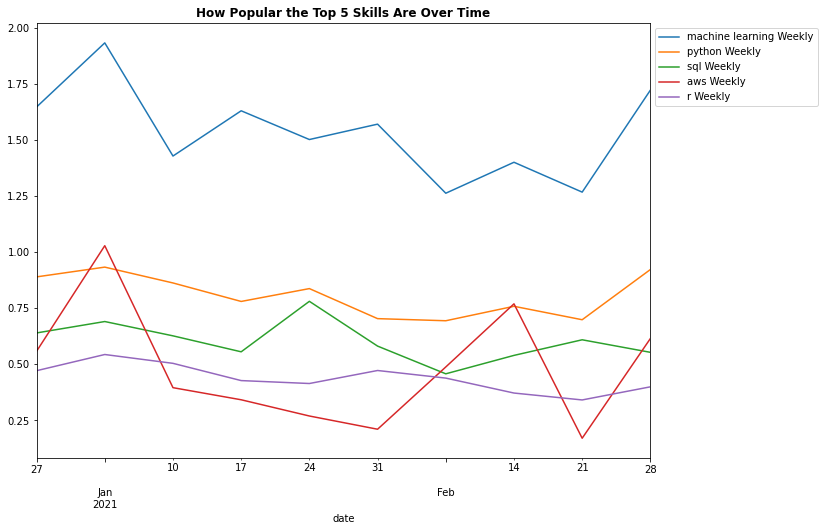

In [200]:
plot_top_skill_ts(df_ds_tx, df_ds_top_tech)

### Skills Match Job Search

In [24]:
# Define a function to find the job position that match the skills of a applicant

def skills_match_search(job_title, skills):
    '''
    '''  
    # Create the initials of the job_title
    initials = job_title_initials(job_title)
    # Load the file path
    database = env_Shi.database
    # Create the file name
    file_name = 'df_' + initials + '_tx_prepared_backup.json'
    # Load the job postings file
    df = pd.read_json(f'{database}{file_name}')
    # Create a list variable to hold the boolean values
    mask = []
    # For loop 
    for clean in df.clean:
        if all(skill in clean for skill in skills):
            mask.append(True)
        else:
            mask.append(False)
    df_match = df[mask]
    # Drop redudant columns
    cols = ['date', 'zipcode', 'clean', 'tokenized', 'stemmed', 'lemmatized']
    df_match.drop(columns=cols, inplace=True)
    print("Number of the Matched Companies: ", df_match.shape[0])
    return df_match

In [25]:
skills = ['python', 'sql', 'tableau', 'aws']

df = skills_match_search('data scientist', skills)
df.shape

Number of the Matched Companies:  72


(72, 7)

In [28]:
df.sample(2)

,title,company,company_rating,job_link,job_description,city,state
464,Cloud Data Engineer,Spectral MD,0.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Company OverviewSpectral MD, Inc. is a medical...",Dallas,TX
370,Cloud Data Engineer\nnew,Spectral MD,0.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Company OverviewSpectral MD, Inc. is a medical...",Dallas,TX


In [41]:
# Create the masks for different skills

mask_python = df_ds_tx.clean.str.contains('python')
mask_sql = df_ds_tx.clean.str.contains('sql')
mask_ml = df_ds_tx.clean.str.contains('machine learning')
mask_tableau = df_ds_tx.clean.str.contains('tableau')
mask_aws = df_ds_tx.clean.str.contains('aws')

mask = mask_python & mask_sql & mask_tableau & mask_aws

In [42]:
# How many companies need all three skills: python, sql and tableau
mask.sum()

72

In [19]:
df_ds_tx[mask].head(1)

,title,company,company_rating,job_link,job_description,city,state,zipcode,clean,tokenized,stemmed,lemmatized
date,,,,,,,,,,,,
2021-02-19,"Analyst, Data Science - Product Analytics",Expedia Group,3.9,https://www.indeed.com/rc/clk?jk=e447fed7ec145...,This is a great opportunity to join Vrbo’s glo...,Austin,TX,78758,great opportunity join vrbos global analytics ...,this is a great opportunity to join vrbos glob...,thi is a great opportun to join vrbo global an...,this is a great opportunity to join vrbos glob...


In [ ]:
df_ds_tx.clean[0][:100]